In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from sklearn.metrics import roc_auc_score

In [3]:
def build_distances(train_line, test_line):
    
    train_pre_arr = np.absolute(train_line[None, :] - train_line[:, None])
    test_pre_arr = np.absolute(train_line[None, :] - test_line[:, None])
    
    train_max = train_pre_arr.max() + 0.01

    return train_pre_arr / train_max, test_pre_arr / train_max

In [4]:
def recombination(train_df, test_df):
    # пока что уберем из рассмотрения столбец Number, т.к. я не знаю, что с ним делать
    
    columns = train_df.columns
    
    train_len = train_df['САД'].__len__()
    test_len = test_df['САД'].__len__()
    
    train_pairwise = np.zeros((train_len, train_len))
    test_pairwise = np.zeros((test_len, train_len))
    
    for col in columns:
        
        train_arr = np.array(train_df[col])
        test_arr = np.array(test_df[col])
        
        train_dist, test_dist = build_distances(train_arr, test_arr)
        
        position = np.where(features == col)[0][0]
        
        train_pairwise += train_dist
        test_pairwise += test_dist
        
    return train_pairwise, test_pairwise

In [5]:
features = np.array(['HLDF (нг/мл', 'САД', 'ДАД', 'Number', 'Триглицериды',
       'ГЛЖ ин Соколова-Лайона', 'Креатинин', 'индекс массы тела',
       'прием п\щ контрац', 'Мочевина', 'Мочевая к-та',
       'VEGF,  пг/мл (N40-600)', 'Холестерин', 'age', 'Х-ЛПВП',
       'АТ к Анг  II ', 'Глюкоза', 'phys', 'Х-ЛПНП', 'АТ к HLDF- 24',
       'S100b, нг/л (N до 90)', 'Анг II, пг/мл (N 10-60 пг/мл)',
       'excess_salt_consumption', 'mind', 'АТ к ЭТ ', 'female',
       'ЭТ, пмоль/л    (N =0,09)', 'насл, Отяг по почечн, Заб', 'гиподинамия',
       'стресс', 'male', 'АТ к S100b', 'no_spec_gender', 'smoking',
       'Alcoholic', 'насл отяг, По ГБ, ', 'насл отяг, По ССЗ',
       'насл отяг, По СД'])

In [6]:
percentiles = np.array([100., 100.,  99.,  97.,  61.,  60.,  51.,  38.,  32.,  31.,  31.,
        31.,  23.,  19.,  17.,  11.,  10.,   8.,   8.,   7.,   5.,   5.,
         4.,   4.,   4.,   2.,   2.,   2.,   1.,   1.,   1.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [7]:
data = pd.read_csv("Data_transformed.csv").fillna(-100)
data.head(5)

,Number,Глюкоза,Мочевина,Креатинин,Мочевая к-та,Холестерин,Х-ЛПВП,Х-ЛПНП,Триглицериды,индекс массы тела,...,АТ к Анг II,АТ к ЭТ,АТ к HLDF- 24,Target,phys,mind,age,male,female,no_spec_gender
0,2.0,6.2,5.9,110,443,6.2,1.07,4.25,2.37,20.00,...,-100.0,-100.0,-100.0,-1,3,0,63.0,1,0,0
1,3.0,5.2,5.0,72,164,5.5,2.27,3.39,0.64,20.69,...,-100.0,-100.0,-100.0,-1,1,2,57.0,0,1,0
2,4.0,5.1,5.8,85,345,6.6,2.10,4.14,0.36,30.47,...,-100.0,-100.0,-100.0,-1,1,2,57.0,0,0,1
3,5.0,5.6,5.7,74,438,6.3,1.04,3.96,3.38,31.80,...,1600.0,400.0,50.0,-1,1,1,55.0,1,0,0
4,12.0,5.7,5.5,88,286,7.1,0.91,5.33,1.80,26.50,...,400.0,600.0,100.0,-1,3,0,60.0,1,0,0


In [8]:
rates = np.unique(percentiles)
rates

array([  0.,   1.,   2.,   4.,   5.,   7.,   8.,  10.,  11.,  17.,  19.,
        23.,  31.,  32.,  38.,  51.,  60.,  61.,  97.,  99., 100.])

In [9]:
neighbours_am = np.arange(15) + 1
neighbours_am

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [10]:
target_col = np.array(data["Target"])
data.drop(columns = "Target", inplace = True)

In [11]:
splits_am = 8
cv = KFold(n_splits=splits_am, shuffle = True, random_state=451)

## Оптимизируем KNN (признаки)

In [13]:
auc_list = []
modifiers_list = []

for threshold in rates:
    for neigh in neighbours_am:
        for dist in ['distance', 'uniform']:
            kept_ft = features[np.where(percentiles >= threshold)[0]]
            removed_ft = list(set(data.columns.tolist()).difference(set(kept_ft.tolist())))
            eval_data = data.drop(columns = removed_ft)

            model = KNeighborsClassifier(n_neighbors=neigh,
                                         weights=dist)

            cv_roc = 0
            modifiers_list.append([threshold, neigh, dist])
            
            for train_index, test_index in cv.split(eval_data):
                
                X_train = eval_data.loc[train_index]
                X_test = eval_data.loc[test_index]
                
                y_train = target_col[train_index]
                y_test = target_col[test_index]
                
                model.fit(X_train, y_train)
                
                preds = model.predict_proba(X_test)[:, 1]
                
                cv_roc += roc_auc_score(y_test, preds)
                
            auc_list.append(cv_roc / splits_am)

In [14]:
np.argmax(auc_list)

490

In [15]:
modifiers_list[514]

[61.0, 3, 'distance']

In [16]:
auc_list[514]

0.5203166335978836

Первый оптимум: 3 соседа, отсечка по 61%, расстояние

Усложним проверку, откинув заранее неработоспособные границы (для уменьшения общего времени работы)

In [27]:
np.argwhere(np.array(auc_list) > 0.80).T

array([[390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
        403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
        416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
        429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
        442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454,
        455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
        468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480,
        481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493,
        494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506,
        507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519,
        520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532,
        533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545,
        546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558,
        559, 560, 561, 562, 563, 564, 565, 566, 567

In [28]:
modifiers_list[390]

[32.0, 1, 'distance']

Т.е. необходимый минимум - 32%

In [18]:
new_rates = rates[13:]
new_rates.__len__()

8

In [20]:
ind_1 = (np.random.rand(25) * 10000).astype(int)
ind_2 = (np.random.rand(25) * 1000).astype(int)
ind_3 = (np.random.rand(25) * 100).astype(int)

random_states = np.concatenate([ind_1, ind_2, ind_3])

In [96]:
random_states

array([9732, 3195, 4718, 9078, 8918, 5174, 2395, 7524, 3837, 7432, 6916,
       7248, 5808, 6199, 5950, 7714, 4622, 5459, 2652, 1445, 6376, 7993,
       3373, 5810, 9201,  612,  556,  129,  849,  533,  697,  523,  945,
        338,  756,  221,  439,  590,  743,  752,  408,  261,  864,  224,
        274,   30,  570,  450,  439,   14,   26,   69,   87,   80,   83,
         98,   94,   95,   10,   55,   38,    8,   46,    8,   65,   79,
         89,   83,   66,    6,   37,   35,   81,   27,   22])

In [97]:
new_auc_list = []
new_modifiers_list = []

for threshold in new_rates:
    for neigh in neighbours_am:
        for dist in ['distance', 'uniform']:
            kept_ft = features[np.where(percentiles >= threshold)[0]]
            removed_ft = list(set(data.columns.tolist()).difference(set(kept_ft.tolist())))
            eval_data = data.drop(columns = removed_ft)

            model = KNeighborsClassifier(n_neighbors=neigh,
                                         weights=dist)

            cv_roc = 0
            new_modifiers_list.append([threshold, neigh, dist])
            
            for state in random_states:
                
                cv = KFold(n_splits=splits_am, shuffle = True, 
                           random_state = state)
            
                for train_index, test_index in cv.split(eval_data):

                    X_train = eval_data.loc[train_index]
                    X_test = eval_data.loc[test_index]

                    y_train = target_col[train_index]
                    y_test = target_col[test_index]

                    model.fit(X_train, y_train)

                    preds = model.predict_proba(X_test)[:, 1]

                    cv_roc += roc_auc_score(y_test, preds)

            new_auc_list.append(cv_roc / splits_am / random_states.__len__())

In [98]:
np.argmax(new_auc_list)

223

In [142]:
best_modifier = new_modifiers_list[np.argmax(new_auc_list)]
best_modifier

[100.0, 7, 'uniform']

In [134]:
best_result = new_auc_list[np.argmax(new_auc_list)]

In [143]:
features[percentiles >= 100]

array(['HLDF (нг/мл', 'САД'], dtype='<U29')

In [144]:
order = np.argsort(new_auc_list)[::-1]

In [145]:
np.array(new_modifiers_list)[order]

array([['100.0', '7', 'uniform'],
       ['100.0', '8', 'uniform'],
       ['100.0', '11', 'uniform'],
       ['99.0', '6', 'distance'],
       ['99.0', '8', 'distance'],
       ['99.0', '9', 'distance'],
       ['99.0', '7', 'distance'],
       ['99.0', '10', 'distance'],
       ['100.0', '9', 'uniform'],
       ['100.0', '10', 'uniform'],
       ['99.0', '11', 'distance'],
       ['99.0', '5', 'distance'],
       ['100.0', '12', 'uniform'],
       ['99.0', '12', 'distance'],
       ['99.0', '14', 'distance'],
       ['99.0', '13', 'distance'],
       ['99.0', '15', 'distance'],
       ['99.0', '15', 'uniform'],
       ['99.0', '14', 'uniform'],
       ['100.0', '13', 'uniform'],
       ['99.0', '5', 'uniform'],
       ['99.0', '12', 'uniform'],
       ['100.0', '15', 'uniform'],
       ['99.0', '13', 'uniform'],
       ['100.0', '14', 'uniform'],
       ['100.0', '8', 'distance'],
       ['100.0', '7', 'distance'],
       ['99.0', '11', 'uniform'],
       ['100.0', '9', 'distance'],


Из данного результата можно увидеть, что наилучший показатель на кросс-валидации (запускалось 4 раза с разными сл. разбиениями) дает отсечка по 2 ключевым параметрам + 7 соседей + отсутствие весов
Попробую добавить различные параметры к данной системе в надежде на улучшение результата на той же кросс-валидации

In [132]:
adjusted_column = []
result = []

model = KNeighborsClassifier(n_neighbors=best_modifier[1],
                             weights=best_modifier[2])

for column in successor_ft:
    
    current_columns = best_subset + [column]
    #print(current_columns)
    outlier_columns = list(set(data.columns.tolist()).difference(set(current_columns)))  
    
    eval_data = data.drop(columns = outlier_columns)
    
    adjusted_column.append(column)
    
    cv_roc = 0
    
    for state in random_states:
        
        cv = KFold(n_splits=splits_am, shuffle = True, 
                           random_state = state)
            
        for train_index, test_index in cv.split(eval_data):

            X_train = eval_data.loc[train_index]
            X_test = eval_data.loc[test_index]

            y_train = target_col[train_index]
            y_test = target_col[test_index]

            model.fit(X_train, y_train)

            preds = model.predict_proba(X_test)[:, 1]

            cv_roc += roc_auc_score(y_test, preds)

    result.append(cv_roc / splits_am / random_states.__len__())    

In [133]:
result

[0.9065499605222819,
 0.9352817126656426,
 0.9129306380348055,
 0.7609985045598144,
 0.8321115484713699,
 0.9144534472141614,
 0.9217091384805677,
 0.9260817869630379,
 0.9136147109284025,
 0.9139812753714546,
 0.9350251100861235,
 0.9359832103522594,
 0.8179906882469384,
 0.9379052679353288,
 0.9146520490202035,
 0.9313042433866853,
 0.9174497985700365,
 0.9346574174612876,
 0.9035941239536479,
 0.9165523613842065,
 0.9328563275789482,
 0.9117073319978097,
 0.9119558679636067,
 0.9220583682411087,
 0.8619967254636901,
 0.9351994706021505,
 0.9168454561311709,
 0.9344235286869222,
 0.8427763501379582,
 0.9175214792042179,
 0.9263252189278991,
 0.9245468212343216,
 0.930479238948883,
 0.9348699030466889,
 0.8304771751396753,
 0.9167677494683454]

In [139]:
np.argwhere(result > best_result).T[0]

array([11, 13])

In [155]:
np.argwhere(result > best_result).__len__()

2

Достроим систему признаков до полной, руководствуясь повышением качества работы на кросс-валидации

In [158]:
best_subset = features[np.where(percentiles >= best_modifier[0])[0]].tolist()

In [168]:
successor_ft = list(set(data.columns.tolist()).difference(set(best_subset)))  

In [169]:
while True:
    adjusted_column = []
    result = []

    model = KNeighborsClassifier(n_neighbors=best_modifier[1],
                                 weights=best_modifier[2])

    for column in successor_ft:

        current_columns = best_subset + [column]
        #print(current_columns)
        outlier_columns = list(set(data.columns.tolist()).difference(set(current_columns)))  

        eval_data = data.drop(columns = outlier_columns)

        adjusted_column.append(column)

        cv_roc = 0

        for state in random_states:

            cv = KFold(n_splits=splits_am, shuffle = True, 
                               random_state = state)

            for train_index, test_index in cv.split(eval_data):

                X_train = eval_data.loc[train_index]
                X_test = eval_data.loc[test_index]

                y_train = target_col[train_index]
                y_test = target_col[test_index]

                model.fit(X_train, y_train)

                preds = model.predict_proba(X_test)[:, 1]

                cv_roc += roc_auc_score(y_test, preds)

        result.append(cv_roc / splits_am / random_states.__len__())
        
    if np.argwhere(result > best_result).__len__() == 0:
        break
        
    added_ind = np.argmax(result)
    added_col = adjusted_column[added_ind]
    
    best_subset = best_subset + [added_col]
    best_result = np.max(result)
    successor_ft.remove(added_col)

In [170]:
best_subset

['HLDF (нг/мл', 'САД', 'насл, Отяг по почечн, Заб', 'прием п\\щ контрац']

In [172]:
best_result

0.9385407933997232

Полученный результат является наилучшим возможным для данной кросс-валидации для KNN

## Оптимизируем  KNN (расстояния)

In [12]:
r_auc_list = []
r_modifiers_list = []

for threshold in rates:
    for neigh in neighbours_am:
        for dist in ['distance', 'uniform']:
            kept_ft = features[np.where(percentiles >= threshold)[0]]
            removed_ft = list(set(data.columns.tolist()).difference(set(kept_ft.tolist())))
            eval_data = data.drop(columns = removed_ft)

            model = KNeighborsClassifier(n_neighbors=neigh,
                                         weights=dist)

            cv_roc = 0
            r_modifiers_list.append([threshold, neigh, dist])
            
            for train_index, test_index in cv.split(eval_data):
                
                X_train = eval_data.loc[train_index]
                X_test = eval_data.loc[test_index]
                
                y_train = target_col[train_index]
                y_test = target_col[test_index]
                
                P_train, P_test = recombination(X_train, X_test)
                
                model.fit(P_train, y_train)
                
                preds = model.predict_proba(P_test)[:, 1]
                
                cv_roc += roc_auc_score(y_test, preds)
                
            r_auc_list.append(cv_roc / splits_am)

In [15]:
np.argmax(r_auc_list)

396

In [16]:
np.max(r_auc_list)

0.9479580026455028

In [14]:
r_modifiers_list[580]

[99.0, 6, 'distance']

In [21]:
r_new_auc_list = []
r_new_modifiers_list = []

for threshold in new_rates:
    for neigh in neighbours_am:
        for dist in ['distance', 'uniform']:
            kept_ft = features[np.where(percentiles >= threshold)[0]]
            removed_ft = list(set(data.columns.tolist()).difference(set(kept_ft.tolist())))
            eval_data = data.drop(columns = removed_ft)

            model = KNeighborsClassifier(n_neighbors=neigh,
                                         weights=dist)

            cv_roc = 0
            r_new_modifiers_list.append([threshold, neigh, dist])
            
            for state in random_states:
                
                cv = KFold(n_splits=splits_am, shuffle = True, 
                           random_state = state)
            
                for train_index, test_index in cv.split(eval_data):

                    X_train = eval_data.loc[train_index]
                    X_test = eval_data.loc[test_index]

                    y_train = target_col[train_index]
                    y_test = target_col[test_index]
                    
                    P_train, P_test = recombination(X_train, X_test)

                    model.fit(P_train, y_train)

                    preds = model.predict_proba(P_test)[:, 1]

                    cv_roc += roc_auc_score(y_test, preds)

            r_new_auc_list.append(cv_roc / splits_am / random_states.__len__())

KeyboardInterrupt: 

In [ ]:
np.argmax(r_new_auc_list)

In [ ]:
r_best_modifier = r_new_modifiers_list[np.argmax(r_new_auc_list)]

In [ ]:
r_best_result = np.max(r_new_auc_list)

In [188]:
r_best_subset = features[np.where(percentiles >= r_best_modifier[0])[0]].tolist()

In [191]:
r_best_subset

['HLDF (нг/мл', 'САД', 'ДАД']

In [189]:
r_successor_ft = list(set(data.columns.tolist()).difference(set(r_best_subset)))  

In [192]:
while True:
    adjusted_column = []
    result = []

    model = KNeighborsClassifier(n_neighbors=r_best_modifier[1],
                                 weights=r_best_modifier[2])

    for column in successor_ft:

        current_columns = r_best_subset + [column]
        #print(current_columns)
        outlier_columns = list(set(data.columns.tolist()).difference(set(current_columns)))  

        eval_data = data.drop(columns = outlier_columns)

        adjusted_column.append(column)

        cv_roc = 0

        for state in random_states:

            cv = KFold(n_splits=splits_am, shuffle = True, 
                               random_state = state)

            for train_index, test_index in cv.split(eval_data):

                X_train = eval_data.loc[train_index]
                X_test = eval_data.loc[test_index]
                
                P_train, P_test = recombination(X_train, X_test)

                y_train = target_col[train_index]
                y_test = target_col[test_index]

                model.fit(P_train, y_train)

                preds = model.predict_proba(P_test)[:, 1]

                cv_roc += roc_auc_score(y_test, preds)

        result.append(cv_roc / splits_am / random_states.__len__())
        
    if np.argwhere(result > r_best_result).__len__() == 0:
        break
        
    added_ind = np.argmax(result)
    added_col = adjusted_column[added_ind]
    
    r_best_subset = best_subset + [added_col]
    r_best_result = np.max(result)
    successor_ft.remove(added_col)

In [193]:
r_best_subset

['HLDF (нг/мл',
 'САД',
 'насл, Отяг по почечн, Заб',
 'прием п\\щ контрац',
 'Холестерин']

In [194]:
r_best_result

0.9332184373386756

Т.е. при переводе к попарным расстояниям получаем небольшое падение качества работы алгоритма относительно оптимизированного  KNN

## Random Forest (все параметры)

In [195]:
rf_model = RandomForestClassifier()

In [197]:
rf_result = 0

for state in random_states:
    
    cv = KFold(n_splits=splits_am, shuffle = True, 
               random_state = state)

    for train_index, test_index in cv.split(data):

        X_train = data.loc[train_index]
        X_test = data.loc[test_index]

        y_train = target_col[train_index]
        y_test = target_col[test_index]

        rf_model.fit(X_train, y_train)

        preds = rf_model.predict_proba(X_test)[:, 1]

        rf_result += roc_auc_score(y_test, preds)

rf_result = rf_result / random_states.__len__() / splits_am
rf_result

0.8156514215832668

## Random Forest (отбор параметров)

In [8]:
rates = np.unique(percentiles)
rates

array([  0.,   1.,   2.,   4.,   5.,   7.,   8.,  10.,  11.,  17.,  19.,
        23.,  31.,  32.,  38.,  51.,  60.,  61.,  97.,  99., 100.])

In [198]:
splits_am = 8
cv = KFold(n_splits=splits_am, shuffle = True, random_state=451)


In [226]:
rf_auc_list = []
rf_modifiers_list = []

for threshold in rates:
    kept_ft = features[np.where(percentiles >= threshold)[0]]
    removed_ft = list(set(data.columns.tolist()).difference(set(kept_ft.tolist())))
    eval_data = data.drop(columns = removed_ft)

    cv_roc = 0
    rf_modifiers_list.append([threshold])

    for train_index, test_index in cv.split(eval_data):

        X_train = eval_data.loc[train_index]
        X_test = eval_data.loc[test_index]

        y_train = target_col[train_index]
        y_test = target_col[test_index]

        rf_model.fit(X_train, y_train)

        preds = rf_model.predict_proba(X_test)[:, 1]

        cv_roc += roc_auc_score(y_test, preds)

    rf_auc_list.append(cv_roc / splits_am)

In [246]:
rf_best_result = np.max(rf_auc_list)

In [228]:
rf_modifiers_list[np.argmax(rf_auc_list)]

[61.0]

In [216]:
r_best_subset

['HLDF (нг/мл',
 'САД',
 'насл, Отяг по почечн, Заб',
 'прием п\\щ контрац',
 'Холестерин']

In [217]:
best_subset

['HLDF (нг/мл', 'САД', 'насл, Отяг по почечн, Заб', 'прием п\\щ контрац']

In [219]:
rf_best_subset = features[percentiles >= 61]
rf_best_subset

array(['HLDF (нг/мл', 'САД', 'ДАД', 'Number', 'Триглицериды'],
      dtype='<U29')

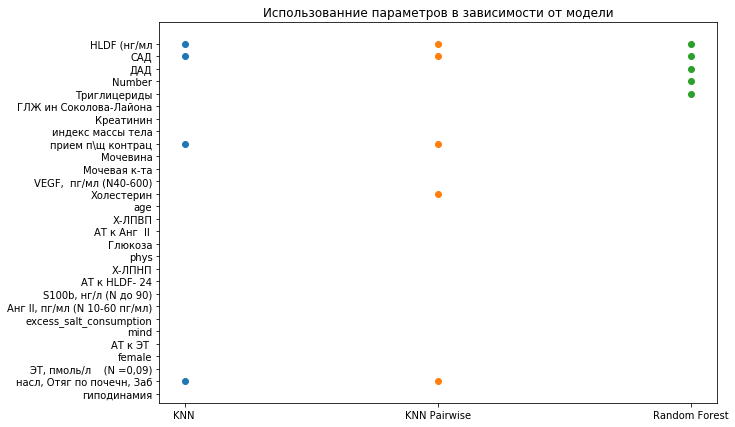

In [243]:
fig = plt.figure(figsize = [10, 7])

plt.scatter(np.zeros(features.__len__()), features, color = 'white')
plt.scatter(["KNN "] * 4, best_subset)
plt.scatter(["KNN Pairwise"] * 5, r_best_subset)
plt.scatter(["Random Forest"] * 5, rf_best_subset)
plt.gca().invert_yaxis()
plt.title("Использованние параметров в зависимости от модели")

plt.savefig("Useage.png")

In [248]:
res = [best_result, r_best_result, rf_best_result]

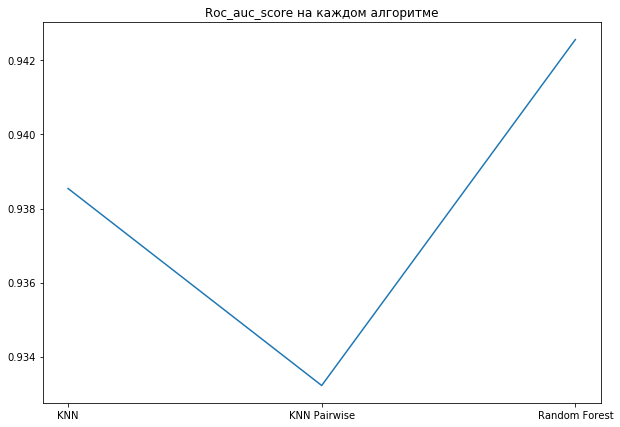

In [251]:
fig = plt.figure(figsize = [10, 7])

plt.plot(["KNN", "KNN Pairwise", "Random Forest"], res)
plt.title("Roc_auc_score на каждом алгоритме")

plt.savefig("Roc.png")

Выкинуть белок и оба давления

Коллаборативная фильтрация

попробовать заменить 0 на пропуск, или среднее расстояние

Поискать выборки по прогнозу прогнозу систалического артериального давления

что значит таргет - п - повышенное давление через год

о - оптимальное давление через год

gradient boosting, svm, logistic regression, decision tree, random forest

попробовать создать ансамбль из этих алгоритмов

стэккинг?

по кардиосигналу + фотоплитизмограмма предсказать давление (будет дан спектр)